# DiT

In [1]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 102 (delta 56), reused 35 (delta 35), pack-reused 22 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [4]:
image_size = 256
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2700611775/2700611775 [01:01<00:00, 43940663.83it/s]
/content/DiT/download.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(local_pat

torch.Size([1, 4, 32, 32])


<ipython-input-30-708c560fa3c9>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load("starting_noise.pt")[0].unsqueeze(0)


  0%|          | 0/250 [00:00<?, ?it/s]

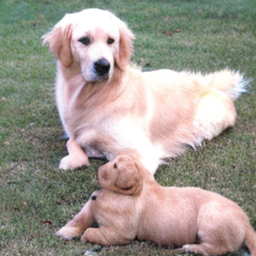

In [30]:
seed = 0
torch.manual_seed(seed)
num_sampling_steps = 250
cfg_scale = 4
class_labels = [207]
samples_per_row = 1

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
z = torch.load("starting_noise.pt")[0].unsqueeze(0)
print(z.shape)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
intermediate_samples = list(diffusion.p_sample_loop_progressive(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
))
samples = intermediate_samples[-1]['sample']
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [31]:
intermediate_samples = [x['sample'] for x in intermediate_samples]
intermediate_samples = torch.stack(intermediate_samples)[:, :1]
torch.save(
    intermediate_samples,
    'dit_intermediate_samples.pt'
)

In [36]:
# prompt: for all 250 steps in intermediate steps, vae decode them and put them in a tensor. save the result to disk

import torch
from torchvision.utils import save_image

decoded_samples = []
for i, step_samples in enumerate(intermediate_samples):
  decoded_step_samples = vae.decode(step_samples / 0.18215).sample
  decoded_samples.append(decoded_step_samples)

# Convert the list of decoded samples to a tensor
decoded_samples_tensor = torch.stack(decoded_samples)

# Save the tensor to disk
torch.save(decoded_samples_tensor, "dit_decoded_intermediate_samples.pt")

<ipython-input-38-4a23a5519448>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_image_tensor = torch.clamp((torch.load("dit_decoded_intermediate_samples.pt")[-50][0] +

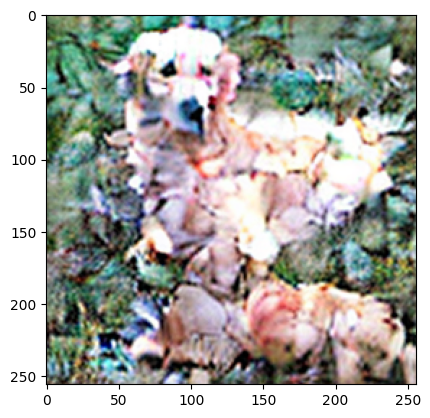

In [38]:
# prompt: visualize last image

from PIL import Image
import matplotlib.pyplot as plt

# Load the last image from the saved tensor
last_image_tensor = torch.clamp((torch.load("dit_decoded_intermediate_samples.pt")[-50][0] + 1) * 127.5, 0, 255)

# Convert the tensor to a PIL Image
last_image = Image.fromarray(last_image_tensor.permute(1, 2, 0).cpu().numpy().astype('uint8'))

# Display the image using matplotlib
plt.imshow(last_image)
plt.show()


# SiT

In [1]:
!git clone https://github.com/willisma/SiT.git
import SiT, os
os.chdir('SiT')
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
!pip install diffusers timm torchdiffeq --upgrade
# SiT imports:
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'SiT'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 44 (delta 13), reused 11 (delta 11), pack-reused 20 (from 1)
Receiving objects: 100% (44/44), 5.92 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (15/15), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 84.1 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

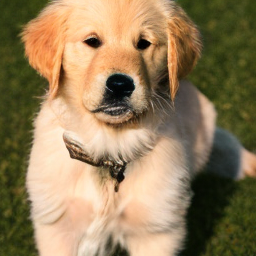

In [8]:
seed = 0
torch.manual_seed(seed)
num_sampling_steps = 250
cfg_scale = 4
class_labels = [207]
samples_per_row = 1
sampler_type = "ODE"


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
z = torch.load("starting_noise.pt")[0].unsqueeze(0)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    diffusion_norm = 1
    last_step = "Mean"
    last_step_size = 0.4
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form,
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size,
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )
intermediate_samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[:, :1]
samples = intermediate_samples[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [ ]:
torch.save(intermediate_samples, 'intermediate_samples.pt')

In [37]:
# prompt: for all 250 steps in intermediate steps, vae decode them and put them in a tensor. save the result to disk

import torch
from torchvision.utils import save_image

decoded_samples = []
for i, step_samples in enumerate(intermediate_samples):
#   print(i)
  decoded_step_samples = vae.decode(step_samples / 0.18215).sample
  decoded_samples.append(decoded_step_samples)

# Convert the list of decoded samples to a tensor
decoded_samples_tensor = torch.stack(decoded_samples)

# Save the tensor to disk
torch.save(decoded_samples_tensor, "sit_decoded_intermediate_samples.pt")

<ipython-input-24-8a58a782ef85>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_image_tensor = torch.clamp((torch.load("decoded_intermediate_samples.pt")[-50][0] + 1) 

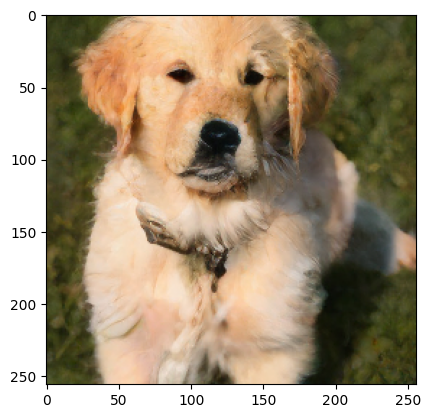

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the last image from the saved tensor
last_image_tensor = torch.clamp((torch.load("sit_decoded_intermediate_samples.pt")[-50][0] + 1) * 127.5, 0, 255)

# Convert the tensor to a PIL Image
last_image = Image.fromarray(last_image_tensor.permute(1, 2, 0).cpu().numpy().astype('uint8'))

# Display the image using matplotlib
plt.imshow(last_image)
plt.show()
